<h1>QBUS6850: Tutorial 6 - High Dimensional Classification</h1>


## Objective
In this tutorial guide we will:
- Generate synthetic data from a non-linear model
- Attempt to seperate (classify) the data using linear SVM
- Seperate data using kernel SVM
- Apply SVM to a practical problem of classifying face images

We will cover the three types of SVM:
- Hard margin
- Soft margin
- Soft margin with kernel

## Generate synthetic data

In [1]:
"""
Generate some non-linearly seperable data
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from matplotlib.colors import ListedColormap 

# 1 - Intialise the RNG
np.random.seed(1)

# 2 - Set the number of points to be created in each class
N = 100

# 3 - Generate the inner data
inner_mean = (0, 0)
inner_cov = [[10, 0], [0, 10]]
inner = np.random.multivariate_normal(inner_mean, inner_cov, N)

# 4 - Generate the outer data
dist_mean = 10
dist_var = 1
radius = dist_var * np.random.randn(N, 1) + dist_mean
angles = np.random.rand(N, 1) * (2*np.pi)
outer_x = radius * np.cos(angles)
outer_y = radius * np.sin(angles)
outer = np.concatenate( (outer_x, outer_y), axis = 1)

# 5 - Plot the data
fig0 = plt.figure()
plt.plot(inner[:,0], inner[:,1], 'o', color = 'b')
plt.plot(outer[:,0], outer[:,1], 'o', color = 'r')
fig0

<Figure size 640x480 with 1 Axes>

We then combine the two groups of points into a single matrix $X$. Since the SVM classifier function expects a single data matrix. We also create a label or target vector $y$.

In [2]:
X = np.concatenate( (inner, outer), axis = 0)
y = np.concatenate( (np.ones(N), np.zeros(N)) , axis = 0)

## Linear SVM 

### Hard Margin

The goal is to construct a separating hyperplane that maximizes the margin of separation. Review
lecture slides 13-16 on the objective function of Hard Margin SVM.

### Soft Margin

The hard margin classifier is very inflexible. It assumes that the data is perfectly linearly seperable.
It does not allow any points to lie within the margin whatsoever. This is very unrealistic, even for
very clean and easy datasets. In most circumstances we need to relax the constraints.
The constraints should be replaced with a function that can softly expresses the fitting error (i.e.
how far and how many points are inside the margin) and be able to be minimized simultaneously
with the margin denominator. Such a function is the hinge loss function

$$ \max(0, 1 - t_n(\mathbf {\beta^T} \mathbf x_n + \beta_0) ) $$

This function is zero when the points are outside the margin, otherwise the value is proportional
to the distance inside the margin.
By replacing the constraints with the hingle loss function we can softly regularise and allow
flexibility in our model i.e. some points can lie inside the margin, check the lecture 5 slide 26 for
the objective function.

We also introduce C to control the tradeoff between the margin size and the “misclassification”.

### Classification

To evaluate the classification for a new data point $\mathbf x_n$ one should use the sign function e.g.

$$ y = \text{sgn}(\mathbf {\beta^T} \mathbf x + \beta_0)$$

The intuition being that the inner product of the normal vector $\mathbf \beta$ and $\mathbf x$ will be positive on one side and negative on the other, corresponding to the two classes.

### Example

In the code below we train a linear SVM model with soft margin on the data. Then we plot the decision boundary of the linear SVM.

To plot the decision boundary we produce a grid of sample points. These sample points are input into the predict function, which returns a classification result. Then for each sample point we can plot the colour (class) that each sample point is assigned to. This is one way to visualise the decision boundary for a 2D classifier.

/Users/jkan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linetypes'
  s)


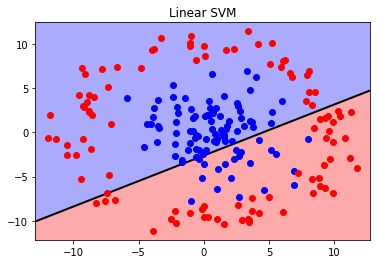

<Figure size 432x288 with 0 Axes>

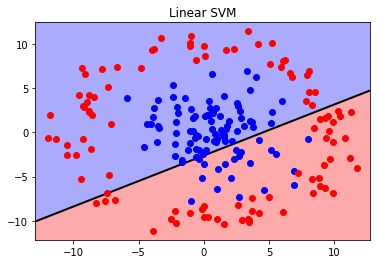

In [3]:
"""
Linear SVM
"""

# Fit the SVM classifier
linear_clf = svm.SVC(kernel = "linear")
linear_clf.fit(X, y)

# Plot the classifier results
fig1 = plt.figure()

# Meshgrid resolution
h = .02

# Meshgrid colours
cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

# Meshgrid boundaries
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# Create the meshgrid coords
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Get predictions over the whole meshgrid
Z = linear_clf.predict(np.c_[xx.ravel(), yy.ravel()])  
Z = Z.reshape(xx.shape)

# Plot the mesh
fig1 = plt.figure()

plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.title('Linear SVM')

# Plot the decision boundary
decis = linear_clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
decis = decis.reshape(xx.shape)
plt.contour(xx, yy, decis, levels=[0], linewidths=2, linetypes='--', colors='k')

# Overlay the original points
plt.plot(inner[:,0], inner[:,1], 'o', color = 'b')
plt.plot(outer[:,0], outer[:,1], 'o', color = 'r')

fig1

## Kernel SVM - Nonlinear Classification

Although SVM is natively a linear method, if we apply a transformation to a higher dimension we may flatten out or linearise the boundary between the two classes. 

You can conceptually understand this as taking two clusters of objects that are very closely spaced. Then spreading them out over an extremely large surface. They are now much easier to seperate.

So we apply a non-linear transformation data to project the data into a higher dimensional space and compute the optimal (maximum margin) hyperplane to seperate the data.


### Kernel Trick

A kernel operator is just a function that computes the distance between two points. Inside the kernel function there is usually an operator that transforms the data to a higher dimension. Check lecture slides for more details.


### The RBF Kernel (Gaussian)

The most popular choice of kernel is the RBF kernel, which is defined as

$$ K(\mathbf x, \mathbf x') = e^{(- \gamma \| \mathbf x - \mathbf x' \|^2)} $$

If you decompose the kernel you will find that it actually relies on a very special mapping $\varphi$ that maps each input vector to an **infinite dimension vector**. To keep things simple we usually prefer to discuss the RBF in terms of the final kernel function instead of the mapping function.

Read the following for further details:

http://pages.cs.wisc.edu/~matthewb/pages/notes/pdf/svms/RBFKernel.pdf

https://stats.stackexchange.com/questions/58585/how-to-understand-effect-of-rbf-svm


### Example

Practically this doesn't change much in our code. We just need to specify the type of kernel we would like. Here are some useful links

http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

http://scikit-learn.org/stable/modules/svm.html#svm-kernels

http://scikit-learn.org/stable/modules/svm.html#svm-classification

/Users/jkan/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/jkan/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linetypes'
  s)


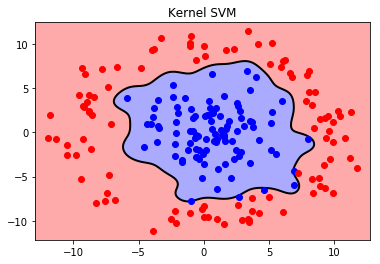

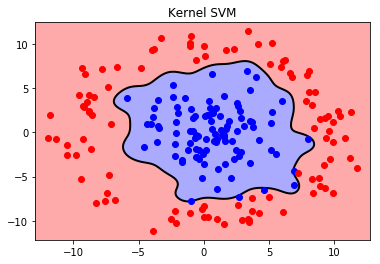

In [4]:
"""
Kernel SVM
"""

kernel_clf = svm.SVC(kernel = "rbf")
kernel_clf.fit(X, y)

fig2 = plt.figure()

h = .02

# Get predictions over the whole meshgrid
Z = kernel_clf.predict(np.c_[xx.ravel(), yy.ravel()])  
Z = Z.reshape(xx.shape)

# Plot the mesh
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
plt.title('Kernel SVM')

# Plot the decision boundary
decis_kernel = kernel_clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
decis_kernel = decis_kernel.reshape(xx.shape)
plt.contour(xx, yy, decis_kernel, levels=[0], linewidths=2, linetypes='--', colors='k')

# Overlay the original points
plt.plot(inner[:,0], inner[:,1], 'o', color = 'b')
plt.plot(outer[:,0], outer[:,1], 'o', color = 'r')

fig2

## SVM - Practical Considerations

### Imbalanced classes

If there is a case where you have a large number of training data for one class you may find that SVM selects a margin that favours coreectly classifying the majority class.

To avoid this we can weight the "constraint" (hinge loss) for each observation/sample OR apply a single shared weight to each class. We should apply a greater weight to the class with less points.

You can apply this weighting one of two ways:
- Specifiy class_weight parameter as "balanced"
- Specifiy class_weight parameter explicity creating your SVC object 
- Speciify indivudal sample_weight parameter when calling your SVC object's .fit() function

http://scikit-learn.org/stable/modules/svm.html#unbalanced-problems

### Multi-class classification

The SVC class implements "one-vs-one" classification for multi-class cases. In other words a SVM classifier is built for every pairwise combination of classes. This gives us a total of $\texttt{n_class * (n_class - 1) / 2}$ classifiers.

The LinearSVC class implements a "one-vs-rest" classification scheme. A SVM classifier is built for each class and the remaining classes are grouped into one large "negative" class for a total of $\texttt{n_class}$ classifiers (except in the two class case, where there is only $1$ classifier).

From either of these positions we can build a final classification from a majority vote of the many classifiers.

http://scikit-learn.org/stable/modules/svm.html#multi-class-classification


## Kernel SVM - Face Recognition of Famous People

We will use SVM to develop a classifier of faces of world leaders.

Due to the relatively large size of the original data we will do
dimension reduction to reduce computational load. We will use PCA for
dimension reduction. These reduced face images are often called "eigenfaces".

Classifying images of human faces is a highly non-linear problem.

Try changing the kernel from "rbf" (radial basis function) to "linear". You
should notice that the classification accuracy is reduced significantly.

In [5]:
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from time import time
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

n_samples, h, w = lfw_people.images.shape

# Use the data vectors directly (as relative pixel positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# The label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: {0}".format(n_samples))
print("n_features: {0}".format(n_features))
print("n_classes: {0}".format(n_classes))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


### Computing the new feature representation (eigenfaces)

In [ ]:
n_components = 150

print("Extracting the top {0} eigenfaces from {1} faces".format(n_components, X_train.shape[0]))
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

### Optimising Parameters via Cross Validation

We must optimise the $\lambda$ parameter and any parameter associated with the kernel. In sklearn the $\lambda$ parameter is called $C$ and our RBF kernel has a parameter $\gamma$.

In [ ]:
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

clf = GridSearchCV(svm.SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("Done in {0:.3f}s".format((time() - t0)))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

###  Evaluating Classification Accuracy

In [ ]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("Done in {0:.3f}s".format((time() - t0)))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

### Visualising Classification Results

In [ ]:
def plot_gallery(images, titles, h, w, n_row, n_col):
    """Helper function to plot a gallery of portraits"""
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return "Predicted: {0}\ntrue:      {1}".format(pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

n_col = 4
n_row = 3
fig3 = plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
plot_gallery(X_test, prediction_titles, h, w, n_row, n_col)
fig3

In [ ]:
eigenface_titles = ["Eigenface {0}".format(i) for i in range(eigenfaces.shape[0])]

fig4 = plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
plot_gallery(eigenfaces, eigenface_titles, h, w, n_row, n_col)
fig4